# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/Progetto AN2DL

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1E-vTKoRQdfaM-gJ1ejZEYjDrQK6K2Mmu/Progetto AN2DL


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import pandas as pd
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2.17.1
TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 🔍 Inpesct Data

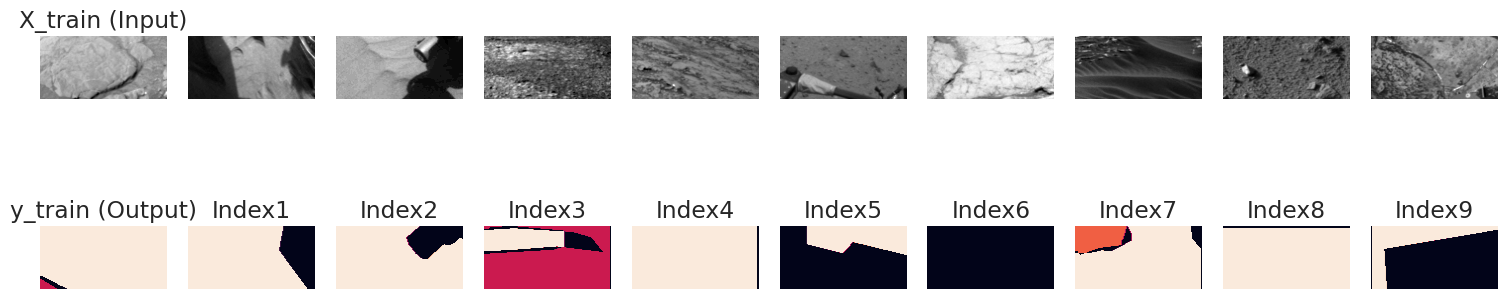

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 casual indices
num_samples = 10
random_indices = np.random.choice(len(X_train), num_samples, replace=False)

# Select 10 images
X_samples = X_train[random_indices]
y_samples = y_train[random_indices]

# Configue figure
fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

# Show X_train images
for i, ax in enumerate(axes[0]):
    ax.imshow(X_samples[i], cmap='gray')
    ax.axis('off')

# Show y_train images
for i, ax in enumerate(axes[1]):
    ax.imshow(y_samples[i])
    ax.set_title(f'Index{i}')
    ax.axis('off')

# Add titles
axes[0][0].set_title("X_train (Input)")
axes[1][0].set_title("y_train (Output)")

plt.tight_layout()
plt.show()

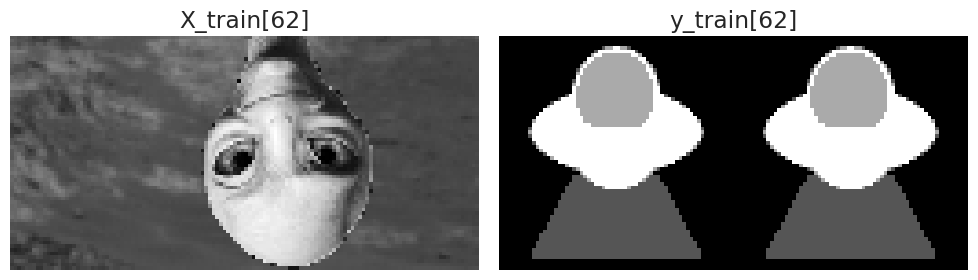

In [ ]:
import matplotlib.pyplot as plt

def display_image_by_index(index, X_train, y_train):
    """
    Visualizza un'immagine da X_train e la corrispondente immagine/etichetta da y_train.

    Args:
        index (int): Indice dell'immagine da visualizzare.
        X_train (numpy.ndarray): Dataset delle immagini di input.
        y_train (numpy.ndarray): Dataset delle etichette o immagini di output.
    """
    if index < 0 or index >= len(X_train):
        print(f"Indice {index} fuori dai limiti. Fornire un valore tra 0 e {len(X_train) - 1}.")
        return

    # Configuration of the image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show image in X_train
    axes[0].imshow(X_train[index], cmap='gray')
    axes[0].set_title(f"X_train[{index}]")
    axes[0].axis('off')

    # Show image and label y_train
    axes[1].imshow(y_train[index], cmap='gray')
    axes[1].set_title(f"y_train[{index}]")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


display_image_by_index(62, X_train, y_train)

## ❌ Eliminate Outliers

In [ ]:
def find_matching_indices(target_index, dataset):
    """
    Trova tutti gli indici nel dataset che contengono immagini uguali a quella di target_index.

    Args:
        target_index (int): Indice dell'immagine di riferimento.
        dataset (numpy.ndarray): Dataset delle immagini da confrontare.

    Returns:
        list: Lista di indici delle immagini uguali.
    """
    # Controlla che l'indice sia valido
    if target_index < 0 or target_index >= len(dataset):
        print(f"Indice {target_index} fuori dai limiti. Fornire un valore tra 0 e {len(dataset) - 1}.")
        return []

    # Immagine di riferimento
    target_image = dataset[target_index]

    # Trova gli indici delle immagini uguali
    matching_indices = [idx for idx, img in enumerate(dataset) if np.array_equal(img, target_image)]

    return matching_indices

# Esempio di utilizzo
target_index = 62
matching_indices = find_matching_indices(target_index, y_train)

print(f"Gli indici delle immagini uguali a y_train[{target_index}] sono: {matching_indices}")


Gli indici delle immagini uguali a y_train[62] sono: [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


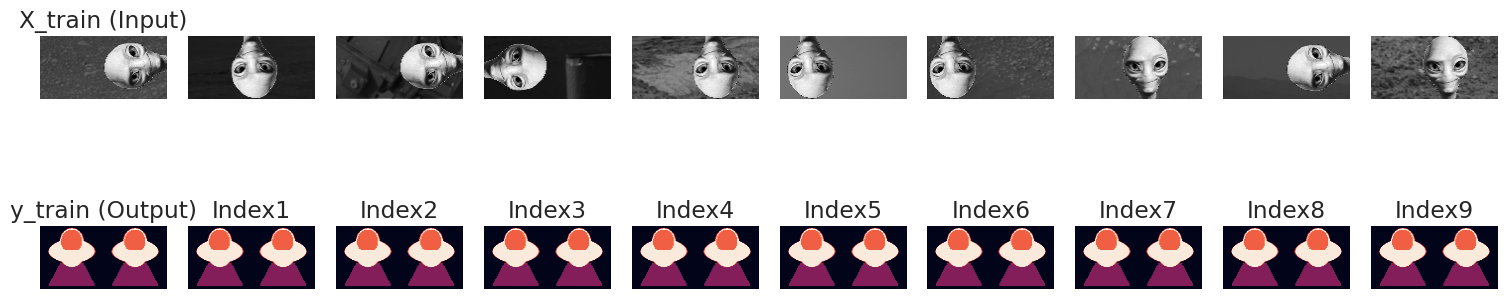

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 unique random indices
num_samples = 10
random_indices = np.random.choice(matching_indices, num_samples, replace=False)

# Select corresponding images and labels
X_samples = X_train[random_indices]
y_samples = y_train[random_indices]

# Set up the figure
fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

# Display the images from X_train
for i, ax in enumerate(axes[0]):
    ax.imshow(X_samples[i], cmap='gray')
    ax.axis('off')

# Display the images or labels from y_train
for i, ax in enumerate(axes[1]):
    ax.imshow(y_samples[i])
    ax.set_title(f'Index{i}')
    ax.axis('off')

# Add optional titles
axes[0][0].set_title("X_train (Input)")
axes[1][0].set_title("y_train (Output)")

plt.tight_layout()
plt.show()

In [ ]:
print(f"Number of aliens: {len(matching_indices)}")

Number of aliens: 110


In [ ]:
# Create a list with the indices of non-duplicate images
all_indices = set(range(len(X_train)))
matching_indices = set(matching_indices)
unique_indices = list(all_indices - matching_indices)

# Create a new dataset without duplicates
X_filtered = X_train[unique_indices]
y_filtered = y_train[unique_indices]

# Check: display the dimensions of the original and deduplicated datasets
print(f"Original dimension of images: {X_train.shape}")
print(f"Dimension of images without duplicates: {X_filtered.shape}")
print(f"Original dimension of labels: {y_train.shape}")
print(f"Dimension of labesls without duplicates: {y_filtered.shape}")

Original dimension of images: (2615, 64, 128)
Dimension of images without duplicates: (2505, 64, 128)
Original dimension of labels: (2615, 64, 128)
Dimension of labesls without duplicates: (2505, 64, 128)


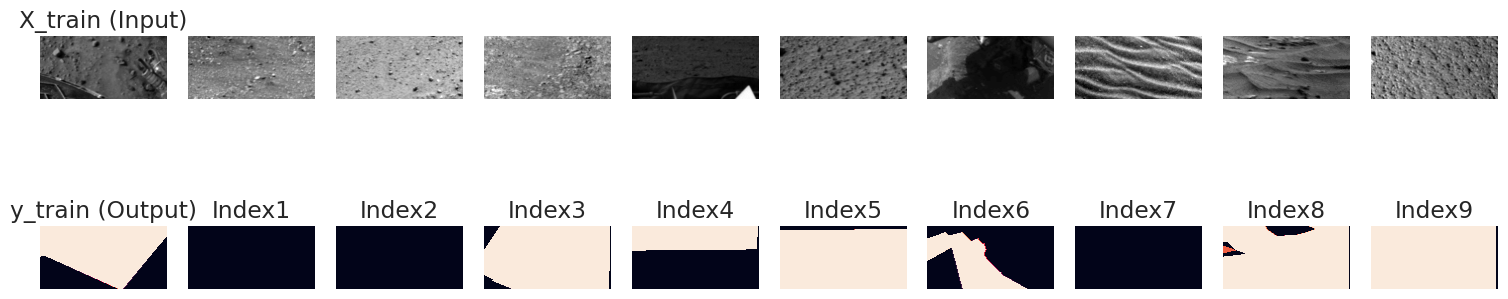

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 unique random indices
num_samples = 10
random_indices = np.random.choice(unique_indices, num_samples, replace=False)

# Select corresponding images and labels
X_samples = X_train[random_indices]
y_samples = y_train[random_indices]

# Set up the figure
fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

# Display the images from X_train
for i, ax in enumerate(axes[0]):
    ax.imshow(X_samples[i], cmap='gray')
    ax.axis('off')

# Display the images or labels from y_train
for i, ax in enumerate(axes[1]):
    ax.imshow(y_samples[i])
    ax.set_title(f'Index{i}')
    ax.axis('off')

# Add optional titles
axes[0][0].set_title("X_train (Input)")
axes[1][0].set_title("y_train (Output)")

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_filtered
y_train = y_filtered

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


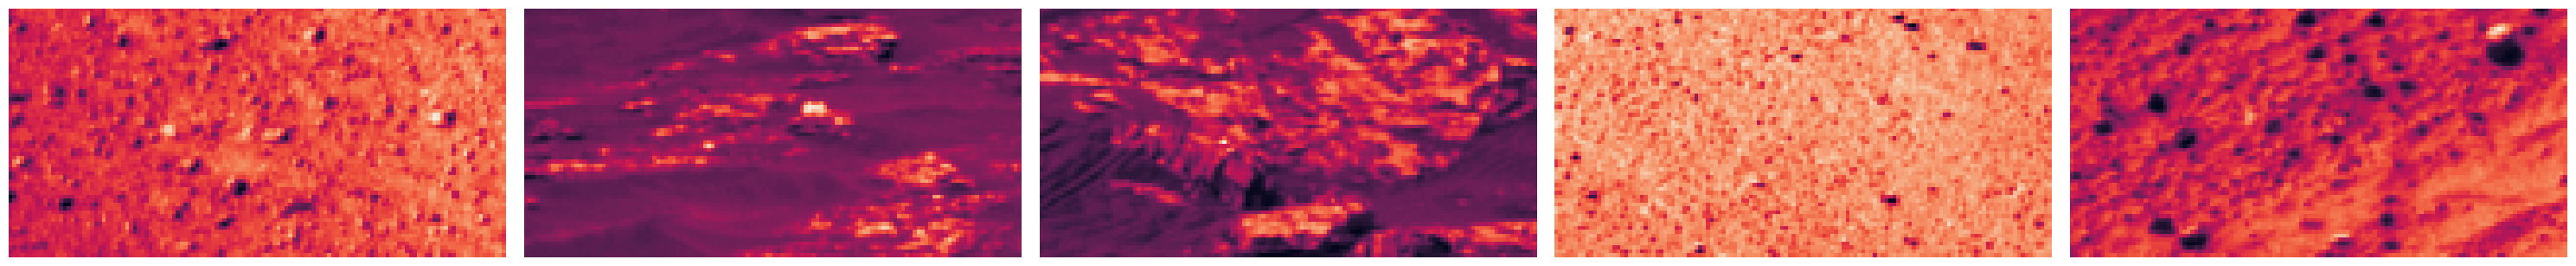

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 unique random indices
num_samples = 5
random_indices = np.random.choice(len(X_train), num_samples, replace=False)

# Select corresponding images and labels
X_samples = X_train[random_indices]

# Set up the figure
fig, axes = plt.subplots(1, num_samples, figsize=(30, 10))

# Display the images from X_train
for i, ax in enumerate(axes):
    ax.imshow(X_samples[i])
    ax.axis('off')


plt.tight_layout()
plt.show()

## 🧮 Define Network Parameters

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {X_train.shape}")
print(f"Number of classes: {num_classes}")
print(f"Unique labels: {X_test.shape}")
print(f"Unique labels: {y_train.shape}")

Input shape: (2505, 64, 128, 1)
Number of classes: 5
Unique labels: (10022, 64, 128, 1)
Unique labels: (2505, 64, 128)


In [ ]:
# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 0.01

# Kernel Size for Convolutional
kernel_size = 3

# Kernel Size for Upsampling
upsampling_size = (2, 2)

# Number of Filters
filters = 64

# Print the defined parameters
#print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Batch Size: 128
Learning Rare: 0.01


In [ ]:
# Split the paths (not the data) into training, validation, and test sets
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=seed
)

# Check the shape of the splits
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")
print("Data splitted!")


X_train shape: (2254, 64, 128, 1), X_val shape: (251, 64, 128, 1)
y_train shape: (2254, 64, 128), y_val shape: (251, 64, 128)
Data splitted!


## 🔣 Build the Model

In [ ]:
def UNet_block(activation,
               normalization = False,
               initializer = None,
               regularizer = None,
               filters = None,
               kernel_size = None,
               upsampling_size = None,
               final_pooling = True,
               final_upsampling = False,
               name = 'Default',
               i=0,
               x = None
):

    # i-th two layer [i.i, i.2] with number of filters equal to filters
    # i.1
    x = tfkl.Conv2D(filters=filters, kernel_regularizer=regularizer, kernel_initializer=initializer,
                    kernel_size=kernel_size, padding='same',
                    name=name + '_conv_'+ str(i) + '.1_f' + str(filters))(x)
    if normalization:
        x = tfkl.BatchNormalization(name=name + 'bn '+ str(i) + '.1')(x)
    x = tfkl.Activation(activation=activation, name=name + '_activation_'+ str(i) + '.1_f_' + str(filters))(x)

    # i.2
    x = tfkl.Conv2D(filters=filters, kernel_regularizer=regularizer, kernel_initializer=initializer,
                    kernel_size=kernel_size, padding='same',
                    name=name + '_conv_'+ str(i) + '.2_f' + str(filters))(x)
    if normalization:
        x = tfkl.BatchNormalization(name=name + 'bn '+ str(i) + '.2')(x)
    x = tfkl.Activation(activation=activation, name=name + '_activation_'+ str(i) + '.2_f' + str(filters))(x)

    # i-th output of the Convolutional Layers before Downsampling or Upsampling
    x_i = x

    # i-th Downsamplig by MaxPooling2D
    if final_pooling:
      x = tfkl.MaxPooling2D(name=name + '_maxpooling_'+ str(i) + '.3_s2')(x)

    # i-th Upsamplig by UpSampling2D
    if final_upsampling:
      x = tfkl.UpSampling2D(size = upsampling_size, interpolation = 'nearest', name = name + '_upsamp_' + str(i) + '.3_s2')(x)

    return x, x_i

In [ ]:
# Use the custom Ranger optimizer in model compilation
def build_model(
    input_shape=input_shape,
    num_classes=num_classes,
    learning_rate=learning_rate,
    kernel_size=kernel_size,
    upsampling_size=upsampling_size,
    filters=filters,
    preprocessing=False,
    normalization=False,
    l2_lambda=5e-4,
    seed=seed,
    activation='relu',
    name='UNet_1.0'
):
    tf.random.set_seed(seed)

    # Regulizer and Initializer
    regularizer = tf.keras.regularizers.l2(l2_lambda)
    initializer = tf.keras.initializers.GlorotNormal(seed=seed)


    # Additional parameters for the UNet
    # Define the number of filter for the downsampling and upsampling
    filters_1 = filters
    filters_2 = 2 * filters
    filters_3 = 4 * filters
    filters_4 = 8 * filters
    filters_5 = 16 * filters

    # Define the size of the upsalmpling
    size=(2, 2)

    # This serves just for the naming of the blocks
    i=1

    # Define the input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')

    if preprocessing:
      x = input_layer #Add the preproccesing layer
    else :
      x = input_layer

    # First two layer [1.1, 1.2, 1.3] with number of filters equal to filters
    x, x_1 = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_1,
                        kernel_size=kernel_size,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Second two layer [2.1, 2.2, 2.3] with number of filters equal to 2*filters
    x, x_2 = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_2,
                        kernel_size=kernel_size,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Third two layer [3.1, 3.2, 3.3] with number of filters equal to 2*filters
    x, x_3 = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_3,
                        kernel_size=kernel_size,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Fourth two layer [4.1, 4.2, 4.3] with number of filters equal to filters
    x, x_4 = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_4,
                        kernel_size=kernel_size,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Fith two layer [5.1, 5.2, 5.3] with number of filters equal to filters
    x, _ = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_5,
                        kernel_size=kernel_size,
                        upsampling_size=upsampling_size,
                        final_pooling = False,
                        final_upsampling = True,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Concatenate x and x_4
    x = tfkl.Concatenate()([x, x_4])

    # Sixth two layer [6.1, 6.2, 6.3] with number of filters equal to filters
    x, _ = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_4,
                        kernel_size=kernel_size,
                        upsampling_size=upsampling_size,
                        final_pooling = False,
                        final_upsampling = True,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Concatenate x and x_3
    x = tfkl.Concatenate()([x, x_3])

    # Sixth two layer [7.1, 7.2, 7.3] with number of filters equal to filters
    x, _ = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_3,
                        kernel_size=kernel_size,
                        upsampling_size=upsampling_size,
                        final_pooling = False,
                        final_upsampling = True,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Concatenate x and x_2
    x = tfkl.Concatenate()([x, x_2])

    # Sixth two layer [8.1, 8.2, 8.3] with number of filters equal to filters
    x, _ = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_2,
                        kernel_size=kernel_size,
                        upsampling_size=upsampling_size,
                        final_pooling = False,
                        final_upsampling = True,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Concatenate x and x_2
    x = tfkl.Concatenate()([x, x_1])

    # Sixth two layer [9.1, 9.2] with number of filters equal to filters
    x, _ = UNet_block(activation=activation,
                        normalization=normalization,
                        regularizer=regularizer,
                        filters=filters_1,
                        kernel_size=kernel_size,
                        upsampling_size=upsampling_size,
                        final_pooling = False,
                        final_upsampling = False,
                        name=name,
                        i=i,
                        x = x)
    i=i+1


    # Add output layer
    output_layer = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding='same',
        activation='softmax',
        kernel_regularizer=regularizer,
        kernel_initializer=initializer,
        name= name + '_output'
    )(x)

    # Create the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name=name)

    # Compile the model with:
    #   Adam optimizer
    #   Sparse Categorical Crossentropy loss
    #   Mean IoU metrics
    # Define the MeanIoU ignoring the background class
    mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
    optimizer = Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = ['accuracy', mean_iou]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

Model: "UNet_1.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_conv_1.1_f64  │ (None, 64, 128, 64)  │          640 │ Input[0][0]         │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_activation_1… │ (None, 64, 128, 64)  │            0 │ UNet_1.0_conv_1.1_… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_conv_1.2_f64  │ (None, 64, 128, 64)  │       36,928 │ UNet_1.0_activatio… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_activation_1… │ (None, 64, 128, 64)  │            0 │ UNet_1.0_conv_1.2_… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_maxpooling_1… │ (None, 32, 64, 64)   │            0 │ UNet_1.0_activatio… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_conv_2.1_f128 │ (None, 32, 64, 128)  │       73,856 │ UNet_1.0_maxpoolin… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_activation_2… │ (None, 32, 64, 128)  │            0 │ UNet_1.0_conv_2.1_… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_conv_2.2_f128 │ (None, 32, 64, 128)  │      147,584 │ UNet_1.0_activatio… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_activation_2… │ (None, 32, 64, 128)  │            0 │ UNet_1.0_conv_2.2_… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_maxpooling_2… │ (None, 16, 32, 128)  │            0 │ UNet_1.0_activatio… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_conv_3.1_f256 │ (None, 16, 32, 256)  │      295,168 │ UNet_1.0_maxpoolin… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_activation_3… │ (None, 16, 32, 256)  │            0 │ UNet_1.0_conv_3.1_… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ UNet_1.0_conv_3.2_f25

 Total params: 31,378,053 (119.70 MB)

 Trainable params: 31,378,053 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

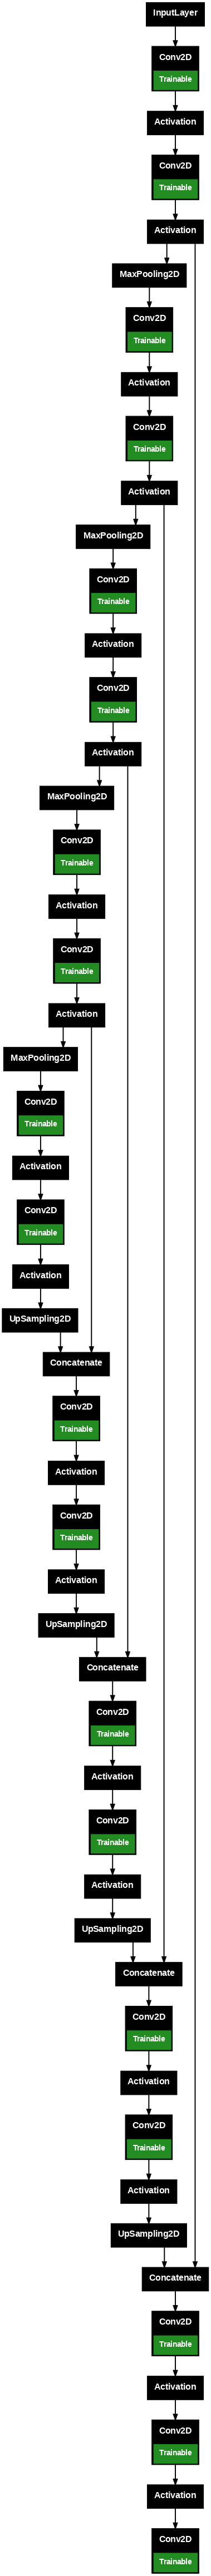

In [ ]:
model = build_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

## 🛠️ Train and Save the Model

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=20
)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step - accuracy: 0.3304 - loss: 1.6690 - mean_io_u: 0.1121
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.3304 - loss: 1.6594 - mean_io_u: 0.1121
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.3304 - loss: 1.6503 - mean_io_u: 0.1121
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.3304 - loss: 1.6414 - mean_io_u: 0.1121
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.3304 - loss: 1.6328 - mean_io_u: 0.1121
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.3304 - loss: 1.6246 - mean_io_u: 0.1121
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.3304 - loss: 1.6166 - mean_io_u: 0.1121
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.3304 - loss: 1.6088 - mean_io_u: 0.1121
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.3304 - loss: 1.6013 - mean_io_u: 0.1121
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━

**testo in grassetto**

In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_220331.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
%cd "/gdrive/MyDrive/Progetto AN2DL"
!mv "/gdrive/MyDrive/Progetto AN2DL/model_241214_220331.keras
!ls

/gdrive/.shortcut-targets-by-id/1E-vTKoRQdfaM-gJ1ejZEYjDrQK6K2Mmu/Progetto AN2DL
/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
'Colab di Davide'								  UNet_32.09.keras
'Consegna (vecchia)'								  UNet_34.75.keras
'Copia di Two UNets working version Homework 2 - Minimal Working Example.ipynb'   UNet_36.01.keras
 mars_for_students.npz								  UNet_39.17.keras
 model_241203_203726.keras							  UNet_41.09.keras
 model_241203_205128.keras							  UNet_41.73.keras
 model_241203_211243.keras							  UNet_42.18.keras
 model_241207_155509.keras							  UNet_42.75.keras
 model_241207_171945.keras							  UNet_42.89.keras
 model_241210_141258.keras							  UNet_43.13.keras
 model_241211_102523.keras							  UNet_43.75.keras
 model_241214_214104.keras							  UNet_44.09.keras
 model_241214_220331.keras							  UNet_44.14.keras
 model.png									  UNet_44.81.keras
'preview of the report.gdoc'							  UNet_44.

In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model("model_241214_220331.keras")
print(f"Model loaded from model_241214_220331.keras")

Model loaded from model_241214_220331.keras


In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```